<ipython-input-3-7b1b38cc2e9f>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(t, 100 / t, 'g', linestyle='dashed', linewidth=3)


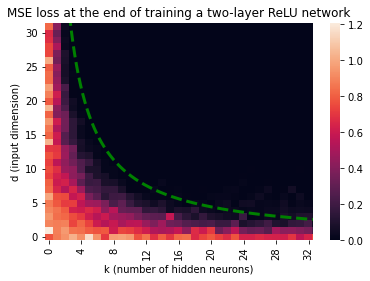

In [3]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# torch.manual_seed(42)
# torch.randn(10, 5)

def get_heatmap(heatmap_filename, xlim=33, ylim=32, title='MSE loss at the end of training a two-layer ReLU network'):
    h = np.load(heatmap_filename)
    ax = sns.heatmap(h)
    ax.set_xlim(right=xlim)
    ax.set_ylim(bottom=ylim)
    ax.invert_yaxis()
    ax.set(xlabel='k (number of hidden neurons)', ylabel='d (input dimension)', title=title)
    t = np.arange(0, 100, .01)
    ax.plot(t, 100 / t, 'g', linestyle='dashed', linewidth=3)
    fig = ax.get_figure()
    return fig
    
    
fig = get_heatmap('results/heatmap_network_type=relu, T=1, m=100, d=99, k=99, d_=1, lr=1.00e-03.npy')
# fig.savefig("heatmap_zoom_in.png")

<ipython-input-3-7b1b38cc2e9f>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(t, 100 / t, 'g', linestyle='dashed', linewidth=3)


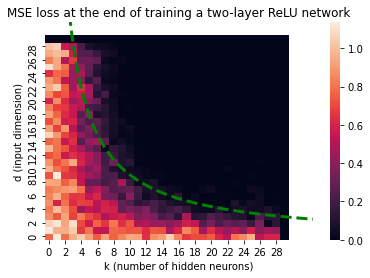

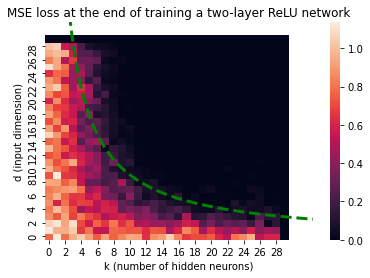

In [4]:
get_heatmap('results/heatmap_network_type=relu, T=1, m=100, d=29, k=29, d_=1, lr=1.00e-01.npy')